In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
import openpyxl
import re
from tqdm import tqdm


In [36]:
plt.rcParams["svg.fonttype"] = "none"

In [37]:
workbook = 'article_info.xlsx'
# workbook = openpyxl.load_workbook(workbook)
# sheet = workbook['articles_selected']

In [38]:
#cinvert the excel sheet to pandas dataframe
article_data = pd.read_excel(workbook, sheet_name='articles_clean')

In [39]:
article_data = article_data[["citation", "n_participants", "dataset", "p_factor_dims", "p_factor_analysis", "biomarker", "biomarker_type", "association"]]

In [40]:
structuraL_biomarkers = ["GMV", "subGMV", "CT", "SA", "f1", "f2", "FA", "RD", "MD", "MO", "SC", "AD", "T1w/T2w", "CD", "L1"]

In [41]:
from itertools import product

def expand_row(row, columns):
    # Split the values in each column and create a product of all combinations
    combinations = product(
        *(str(row[col]).split(', ') for col in columns)
    )
    # Create a list of dictionaries for each combination
    expanded_rows = [
        {**{col: val for col, val in zip(columns, combo)}, **row.drop(columns)}
        for combo in combinations
    ]
    return expanded_rows

# Columns to expand
columns_to_expand = ["p_factor_dims", "p_factor_analysis", "biomarker", "biomarker_type", "association"]

# Apply the expand_row function to each row
expanded_data = [expand_row(row, columns_to_expand) for index, row in article_data.iterrows()]

# Flatten the list of lists into a single list of dictionaries
flat_data = [item for sublist in expanded_data for item in sublist]

# Convert the list of dictionaries back into a DataFrame
expanded_df = pd.DataFrame(flat_data)
# expanded_df = expanded_df[~(((expanded_df['biomarker_type'] == 'structural') & 
#                              (expanded_df['biomarker'] == 'FC')) |
#                             ((expanded_df['biomarker_type'] == 'structural') & 
#                              (expanded_df['biomarker'] == 'CBF')))]

expanded_df = expanded_df[~(((expanded_df['biomarker_type'] == 'structural') & 
                             (expanded_df['biomarker'].isin(["FC", "CBF"]))))]

expanded_df = expanded_df[~(((expanded_df['biomarker_type'] == 'functional') & 
                             (expanded_df['biomarker'].isin(structuraL_biomarkers))))]

In [42]:
def is_valid_combination(row, original_df):
    if ',' in str(row['association']):  # Check only rows with multiple values in 'association'
        # Find the original row(s) this row could have been expanded from
        original_rows = original_df[
            (original_df['citation'] == row['citation']) &
            (original_df['n_participants'] == row['n_participants']) &
            (original_df['dataset'] == row['dataset'])
        ]

        for _, original_row in original_rows.iterrows():
            # Split the original values into lists
            original_associations = str(original_row['association']).split(', ')
            original_biomarkers = str(original_row['biomarker']).split(', ')

            # Check if the current combination exists in the original row
            if len(original_associations) == len(original_biomarkers):
                try:
                    index = original_biomarkers.index(row['biomarker'])
                    if original_associations[index] == row['association']:
                        return True
                except ValueError:
                    continue
        return False
    else:
        return True

# Apply the is_valid_combination function
expanded_df = expanded_df[expanded_df.apply(is_valid_combination, axis=1, original_df=article_data)]

In [43]:
expanded_df[expanded_df['association'] == 'nan']

,p_factor_dims,p_factor_analysis,biomarker,biomarker_type,association,citation,n_participants,dataset
264,internalizing,Bifactor,FM,functional,nan,Reimann et al. (2023),3568,ABCD
265,ADHD,Bifactor,FM,functional,nan,Reimann et al. (2023),3568,ABCD
266,conduct,Bifactor,FM,functional,nan,Reimann et al. (2023),3568,ABCD
286,internalizing,Bifactor,FA,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD
287,internalizing,Bifactor,MD,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD
288,ADHD,Bifactor,FA,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD
289,ADHD,Bifactor,MD,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD
290,conduct,Bifactor,FA,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD
291,conduct,Bifactor,MD,structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD


In [44]:
# replace functional with Functional
expanded_df['biomarker_type'] = expanded_df['biomarker_type'].replace('functional', 'Functional')
expanded_df['biomarker_type'] = expanded_df['biomarker_type'].replace('structural', 'Structural')
expanded_df['association'] = expanded_df['association'].replace('pos', 'Positive')
expanded_df['association'] = expanded_df['association'].replace('neg', 'Negative')
# expanded_df['association'] = expanded_df['association'].replace('nan', 'NULL')

In [50]:
expanded_df[expanded_df['association'] == 'nan']

,p_factor_dims,p_factor_analysis,biomarker,biomarker_type,association,citation,n_participants,dataset
264,internalizing,Bifactor,FM,Functional,nan,Reimann et al. (2023),3568,ABCD
265,ADHD,Bifactor,FM,Functional,nan,Reimann et al. (2023),3568,ABCD
266,conduct,Bifactor,FM,Functional,nan,Reimann et al. (2023),3568,ABCD
286,internalizing,Bifactor,FA,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD
287,internalizing,Bifactor,MD,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD
288,ADHD,Bifactor,FA,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD
289,ADHD,Bifactor,MD,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD
290,conduct,Bifactor,FA,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD
291,conduct,Bifactor,MD,Structural,nan,Cardenas-Iniguez et al. (2022),8588,ABCD


In [46]:
expanded_df.to_csv('expanded_article_data.csv', index=False)

In [34]:
expanded_df = pd.read_csv('expanded_article_data.csv')

## Sorting by Effect & Data Modality

In [49]:
df_associations_biomarkers = expanded_df.drop_duplicates(subset=['citation', 'biomarker', 'biomarker_type', 'association'])

In [ ]:
df_associations_biomarkers['']

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_12805/1309218564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_associations_biomarkers['biomarker_type_jittered'] = df_associations_biomarkers['biomarker_type'].astype('category').cat.codes + 1 + np.random.uniform(-0.7, 0.1, size=len(df_associations_biomarkers))
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_12805/1309218564.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_associations_biomarkers['association_jittered'] = 

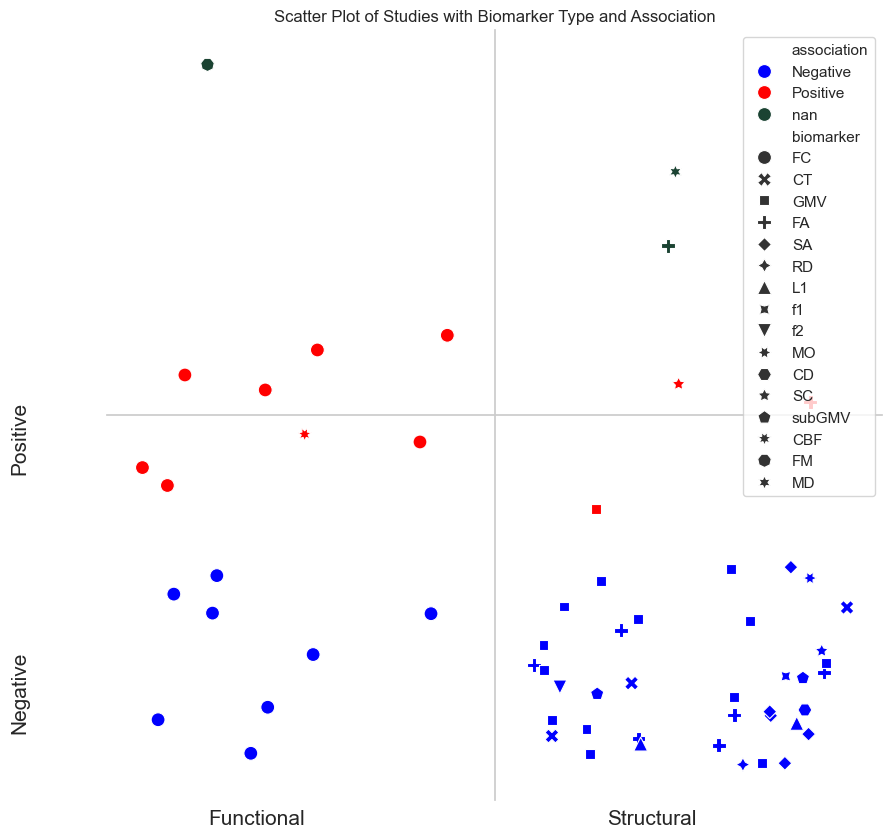

In [51]:
# for this plot only keep the rows with unique combinations of biomarker,biomarker_type	and association
df_associations_biomarkers = expanded_df.drop_duplicates(subset=['citation', 'biomarker', 'biomarker_type', 'association'])
df_associations_biomarkers['biomarker_type_jittered'] = df_associations_biomarkers['biomarker_type'].astype('category').cat.codes + 1 + np.random.uniform(-0.7, 0.1, size=len(df_associations_biomarkers))
df_associations_biomarkers['association_jittered'] = df_associations_biomarkers['association'].astype('category').cat.codes + 1 + np.random.uniform(-0.7, 0.1, size=len(df_associations_biomarkers))

# Create a scatter plot
plt.figure(figsize=(10, 10))

# Plotting the scatter plot
sns.scatterplot(data=df_associations_biomarkers, x='biomarker_type_jittered', y='association_jittered', hue='association', style='biomarker', s=100, palette=['#0000fe', '#ff0000', "#1b4332"])


# # Annotate each point with its citation
# for i, row in expanded_df.iterrows():
#     plt.text(row['biomarker_type_jittered'], row['association_jittered'], row['citation'], horizontalalignment='right', alpha=0.7, fontsize=11)

# Adding axis annotations for 'Negative/Positive' and 'Functional/Structural' directions
biomarker_categories = df_associations_biomarkers['biomarker_type'].astype('category').cat.categories
association_categories = df_associations_biomarkers['association'].astype('category').cat.categories

# Place biomarker type and association annotations
plt.text(biomarker_categories.get_loc('Functional') + 0.6, 0.1, 'Functional', ha='center', va='center', fontsize=15)
plt.text(biomarker_categories.get_loc('Structural') + 0.6, 0.1, 'Structural', ha='center', va='center', fontsize=15)
plt.text(0.000001, association_categories.get_loc('Positive') + 0.6, 'Positive', ha='center', va='center', rotation=90, fontsize=15)
plt.text(0.000001, association_categories.get_loc('Negative') + 0.6, 'Negative', ha='center', va='center', rotation=90, fontsize=15)


# Remove the default x and y ticks and labels
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

# Set the origin in the middle
plt.gca().spines['bottom'].set_position('center')
plt.gca().spines['left'].set_position('center')

# Remove top and right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Scatter Plot of Studies with Biomarker Type and Association')
plt.savefig('scatter_plot.svg', format = 'svg', dpi=300)
plt.show()



## Effects

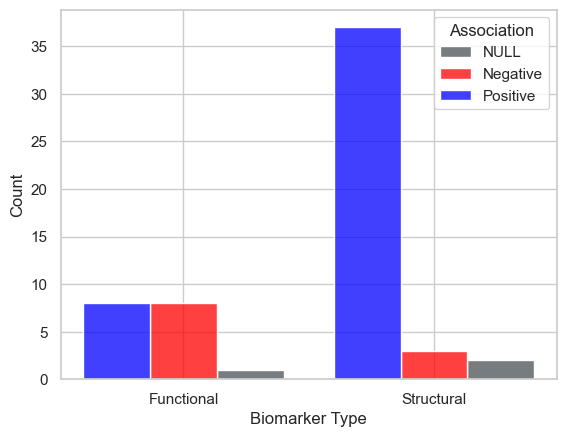

In [117]:
# sns.histplot(data=df_associations_biomarkers, x='biomarker_type', hue='association', multiple='stack', palette=['#0000fe', '#ff0000', '#495057'], shrink=0.8)

sns.set_theme(style="whitegrid")
sns.histplot(data=df_associations_biomarkers, x="biomarker_type", hue="association", multiple="dodge", shrink=.8, palette=['#0000fe', '#ff0000', '#495057'])
plt.xlabel('Biomarker Type')
plt.legend(title='Association', labels=['NULL','Negative','Positive'])
plt.savefig('histplot_associations.svg', format = 'svg', dpi=300)


In [112]:
biomarker_colors = [
    '#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', 
    '#9f4800', '#f14cc1', '#a3a3a3', '#ffc400', '#00d7ff', 
    '#ff5b77', '#a42400', '#001146', '#0094cc', '#e0e0e0', 
    '#000000'
]

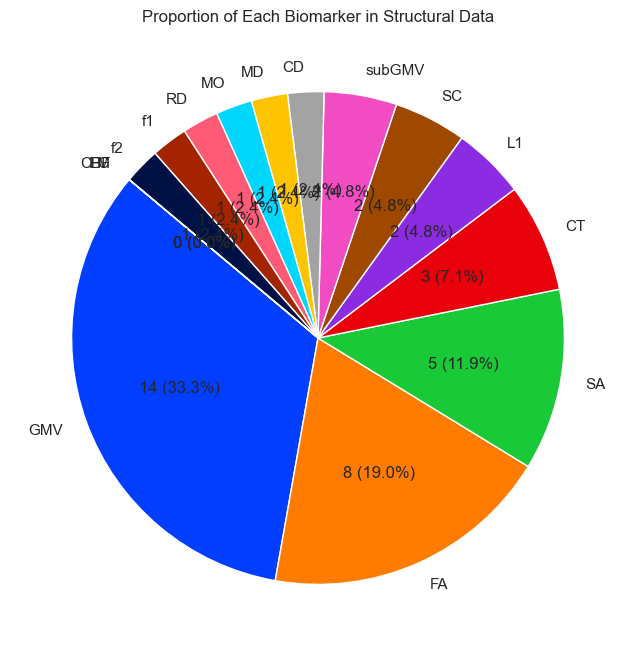

In [113]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v} ({p:.1f}%)'.format(p=pct,v=val)
    return my_format

df_associations_biomarkers_neg = df_associations_biomarkers[df_associations_biomarkers['biomarker_type'] == 'Structural']
biomarker_counts = df_associations_biomarkers_neg['biomarker'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(biomarker_counts, labels=biomarker_counts.index, autopct=autopct_format(biomarker_counts), startangle=140, colors=biomarker_colors)
plt.title('Proportion of Each Biomarker in Structural Data')
plt.savefig('pie_plot_structural.svg', format = 'svg', dpi=300)
plt.show()

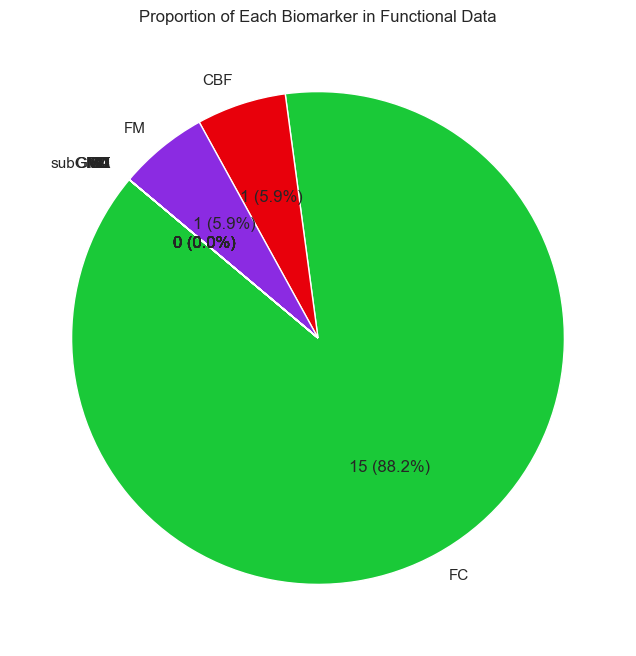

In [116]:
biomarker_colors = ['#1ac938', '#e8000b', '#8b2be2']
df_associations_biomarkers_func = df_associations_biomarkers[df_associations_biomarkers['biomarker_type'] == 'Functional']
biomarker_counts = df_associations_biomarkers_func['biomarker'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(biomarker_counts, labels=biomarker_counts.index, autopct=autopct_format(biomarker_counts), startangle=140, colors=biomarker_colors)
plt.title('Proportion of Each Biomarker in Functional Data')
plt.savefig('pie_plot_functional.svg', format = 'svg', dpi=300)
plt.show()

In [ ]:
df_associations_biomarkers_pos = df_associations_biomarkers[df_associations_biomarkers['association'] == 'Positive']
biomarker_counts = df_associations_biomarkers_neg['biomarker'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(biomarker_counts, labels=biomarker_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Each Biomarker')
plt.show()

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_12805/2276295082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_associations_biomarkers['biomarker'] = df_associations_biomarkers['biomarker'].astype('category')
/Users/VictoriaShevchenko/opt/miniconda3/envs/neuro/lib/python3.9/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1000x1000 with 0 Axes>

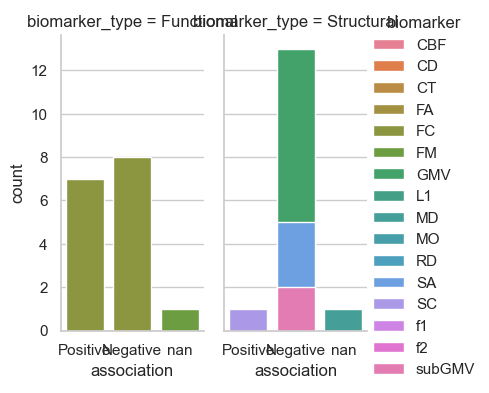

In [70]:
df_associations_biomarkers['biomarker'] = df_associations_biomarkers['biomarker'].astype('category')
# change figure size
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(df_associations_biomarkers, col="biomarker_type", hue = "biomarker", height=4, aspect=.5)
g.map(sns.countplot, "association").add_legend()
#sns.histplot(data=df_associations_biomarkers, x="asso", hue="association", multiple="stack", shrink=.8, palette=['#0000fe', '#ff0000', '#495057'])
#plt.xlabel('Biomarker Type')
#plt.legend(title='Association', labels=['Negative','Positive', 'NULL'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


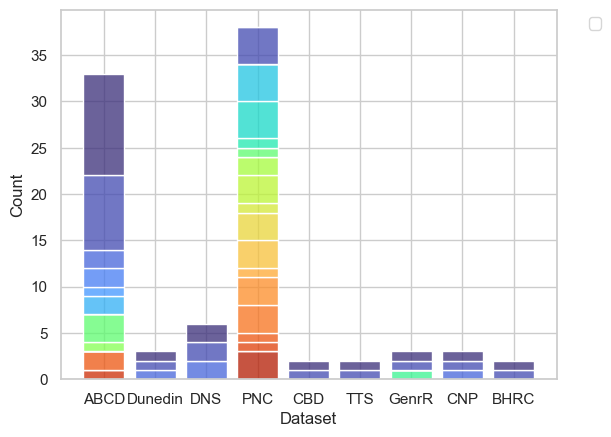

In [80]:
df_datasets = expanded_df.drop_duplicates(subset=['citation', 'dataset', 'p_factor_dims'])
# remove rows with nans in p_factor_dims
df_datasets = df_datasets[df_datasets['p_factor_dims'] != 'nan']
sns.histplot(data=df_datasets, x='dataset', hue='p_factor_dims', multiple='stack', palette= "turbo", shrink=0.8)
sns.set_theme(style="whitegrid")
plt.xlabel('Dataset')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


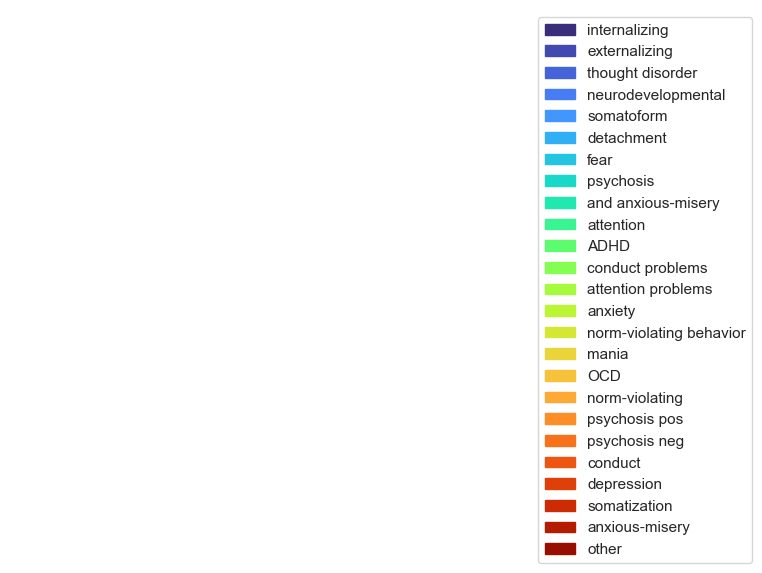

In [81]:
import matplotlib.patches as mpatches

# Define the colors and labels for your legend
colors = sns.color_palette("turbo", len(df_datasets['p_factor_dims'].unique()))
labels = df_datasets['p_factor_dims'].unique()

# Create a list of patches for the legend
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]

# Create the legend
fig, ax = plt.subplots()
legend = plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Hide the axes
ax.axis('off')

# Show the legend
plt.show()

## Dataset and Pfactor Method Frequency

In [4]:

article_data = pd.read_excel(workbook, sheet_name='dataset_pfactor_method')
dataset_data = article_data[["citation", "dataset"]].drop_duplicates(subset = ["citation"])
latent_method = article_data[["citation", "p_factor_analysis"]]

In [15]:
dataset_data

,citation,dataset
0,"Hong, Hwang, & Lee (2023)",ABCD
1,Sripada et al. (2021),ABCD
2,Romer et al. (2021),Dunedin
4,Karcher et al. (2021),ABCD
5,Elliott et al. (2018),DNC
8,Romer et al. (2018),DNC
9,Cui et al. (2022),PNC
10,Zhao et al. (2023),CBD
11,Hinton et al. (2019),TTS
12,Neumann et al. (2020),GenrR


<AxesSubplot: xlabel='dataset', ylabel='Count'>

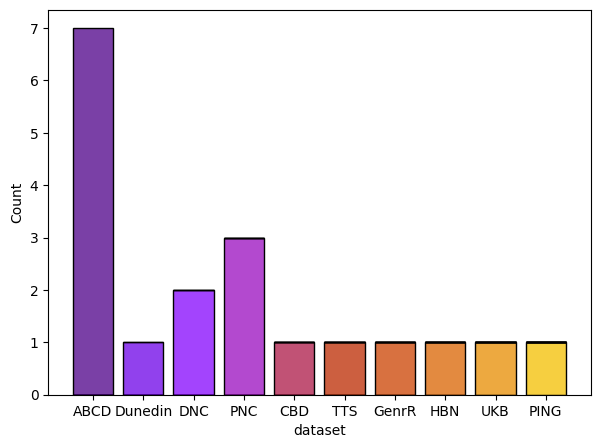

In [5]:
plt.figure(figsize=(7, 5))
sns.histplot(data=dataset_data, x='dataset', hue='dataset', multiple='stack', shrink=0.8, legend=False, palette="gnuplot")

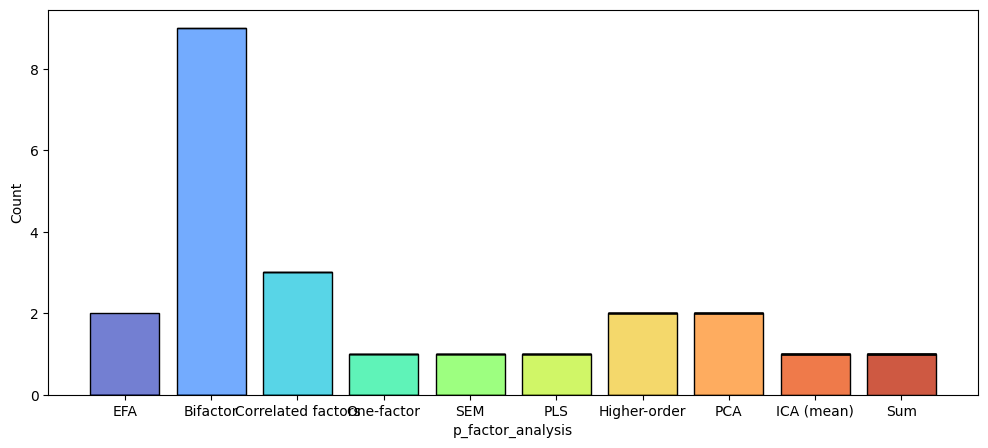

In [9]:
plt.figure(figsize=(12, 5))
sns.histplot(data=latent_method, x='p_factor_analysis', hue='p_factor_analysis', multiple='stack', shrink=0.8, legend=False, palette = "turbo")
plt.savefig('p_factor_analysis_histplot.svg', format = 'svg', dpi=300)

## Psy Dimensions

In [20]:
dim_data = pd.read_excel(workbook, sheet_name='dimensions')
dim_data = dim_data[["citation", "p_factor_dims"]]


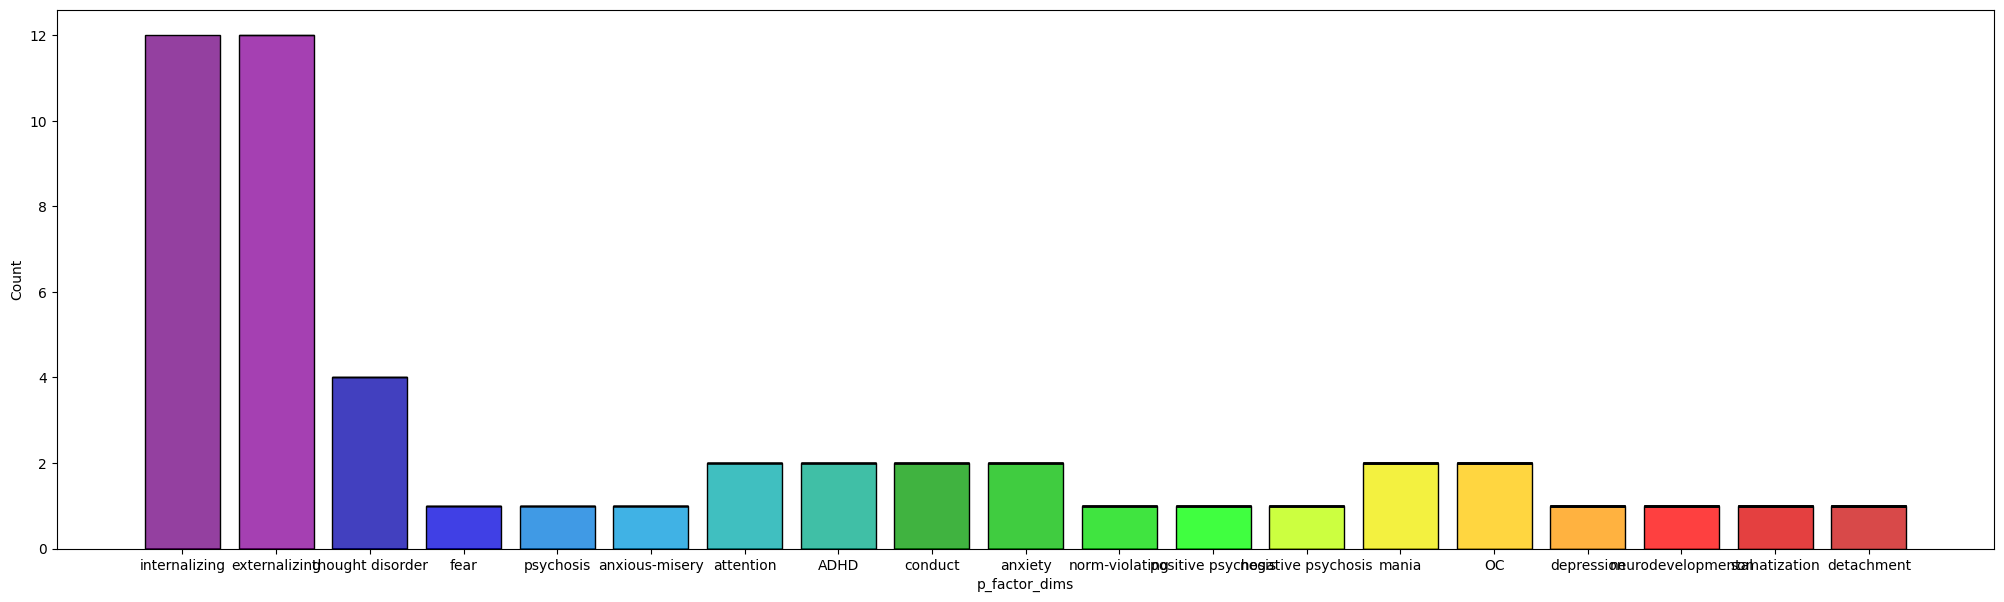

In [23]:
plt.figure(figsize=(25, 7))
sns.histplot(data=dim_data, x='p_factor_dims', hue='p_factor_dims', multiple='stack', shrink=0.8, legend=False, palette = "nipy_spectral")
plt.savefig('p_factor_dims_histplot.svg', format = 'svg', dpi=300)